# 🤖 Mobile robots project - Team 30

<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #E8F5E9; color: #333;">
    <strong>Course:</strong> <span>Basics of Mobile Robotics</span>
    <br><br>
    <strong>Professor:</strong> <span>Francesco Mondada</span>
    <br><br>
    <strong>T30 members:</strong>
    <ul>
        <li><strong>Name:</strong> Jiwon You, <strong>SCIPER:</strong> 394716</li>
        <li><strong>Name:</strong> Adriana Nancy Orellana Torrico, <strong>SCIPER:</strong> 376792</li>
        <li><strong>Name:</strong> Charles Froessel, <strong>SCIPER:</strong> 302841</li>
        <li><strong>Name:</strong> Johann Lugon-Moulin, <strong>SCIPER:</strong> 341451</li>
    </ul>
</div>



-------

# 📖 Project description

In this project, we are going to apply the concepts learned in the Basics of Mobile Robotics course to implement a system with multiple components, including vision, global navigation, local navigation, filtering, and motion control. Our goal is to enable a Thymio robot to navigate through an environment with a map, obstacles, and a goal point, while avoiding potential obstacles that may appear in its path and using motion estimation to improve its localization.

The system begins by detecting the map, obstacles, and goal point using a vision component, which also tracks the Thymio's position in real-time. The global navigation component then uses this information to plan the best path to the goal. Once the global path is computed, the local navigation component guides the Thymio along the path, and if new obstacles appear, the Thymio avoids them and returns to the original path.

In the following sections, we will describe the environment and components of our system in more detail. We will also present the results of our project in various scenarios, including static obstacles (2D shapes), dynamic obstacles (a 3D box), and kidnapping scenarios where the Thymio is moved to a different location on the map and must recompute a path to the goal.

## 1. Environment

For the environment we made the following choices:

- **Map:** Our map has a size of 133 cm x 92 cm. We placed ArUco markers at the corners to facilitate map detection by the vision component.
- **Static obstacles:** We created several convex black paper polygons and placed them at different locations on the map.
- **Dynamic obstacles:** We used a square box as a dynamic obstacle that can appear along the path, and the Thymio must navigate around it.
- **Goal:** The goal is represented by a black circle on the map, which the Thymio must reach.

Below you can see an image of the environment we created:

<div style="text-align: center; margin-top:20px;">
    <strong>Environment captured by the camera</strong>
</div>
<div style="text-align: center; margin-top:20px;">
    <img src='./figures/map_demo.jpeg' width='500'>
</div>

## 2. Components

### 2.1. Vision

**Responsible:** Adriana Nancy Orellana Torrico

The vision component is the responsible to take frames of the environment, preprocess them, and detect meaningful information. In this case, the map, its obstacles, the goal position and identify the thymio robot in real-time. To achieve this we use a camera AUKEY and the [openCV](https://opencv.org/) library. Our solution can be divided in the following steps:

1. Detect the map in the image.
2. Once the map is detected, fix the perspective to have a top view of it.
3. Identify the obstacles and the goal inside the map.
4. Detect the Thymio robot in real-time, providing its position and orientation.

#### Map detection

To detect the map, we first preprocess the image to remove any noise that might interfere with the detection. We use a bilateral filter to achieve this, which removes noise while preserving the sharp edges of the map. Then, we place ArUco markers, which are binary patterns designed to be easily detectable in images and robust to changes in lighting conditions, at each corner of the map. Each ArUco marker has a unique identifier, and thanks to OpenCV, the x and y coordinates of each marker's four corners can be obtained in clockwise order. The following image shows the ArUco markers we used:

- **Top-left corner:** ArUco 2
- **Top-right corner:** ArUco 3
- **Bottom-right corner:** ArUco 4
- **Bottom-left corner:** ArUco 5

<div style="text-align: center; margin-top:20px;">
    <img src='./map/marker_2.png' width='130'>
    <img src='./map/marker_3.png' width='130'>
</div>
<div style="text-align: center;">
    <img src='./map/marker_5.png' width='130'>
    <img src='./map/marker_4.png' width='130'>
</div>
<div style="text-align: center; margin-top:20px;">
    <strong>Aruco markers with identifiers 2, 3 in the first row and 5, 4 in the second row</strong>
</div>

Once we detect these ArUco markers using OpenCV, we get the following corners of each marker:

- Top-left corner of ArUco 2
- Top-right corner of ArUco 3
- Bottom-right corner of ArUco 4
- Bottom-left corner of ArUco 5

With this data, we can correct the perspective of the map to obtain a top-down view, even if the camera is not positioned directly above the map. The following code shows the results of our map detection with perspective correction:

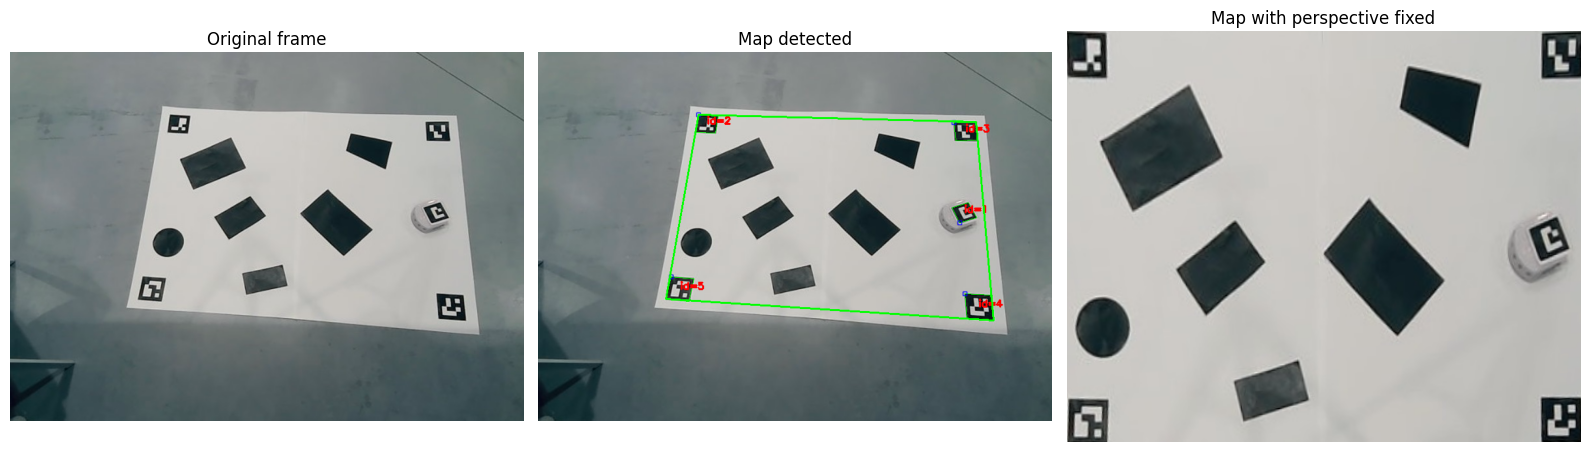

In [1]:
import cv2
import matplotlib.pyplot as plt

from src.cv import *

MAP_MAX_WIDTH = 500
MAP_MAX_HEIGHT = 400

frame = cv2.imread('./figures/map_demo.jpeg')
frame_copy = frame.copy()

map_coords = detect_map(frame_copy, draw_arucos=True)

# Draw the border of the map
cv2.polylines(frame_copy, [map_coords.astype(np.int32)], True, (0, 255, 0), 2)

map_frame = fix_map_perspective(frame, map_coords, MAP_MAX_WIDTH, MAP_MAX_HEIGHT)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.imshow(frame)
plt.title('Original frame')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(frame_copy)
plt.title('Map detected')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(map_frame)
plt.title('Map with perspective fixed')
plt.axis('off')

plt.tight_layout()
plt.show()

#### Obstacle and goal detection

After identifying the map and correcting its perspective, we detect the obstacles and goal within it. To do this, we convert the image to grayscale and apply a Canny filter to detect the edges of all the elements inside the map. This helps us to identify the contours of the obstacles and goal.

We find the contours of all the elements inside the map using `contours, hierarchy = cv2.findContours(canny_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)`,  focusing only on the outer contours and removing redundant points to approximate them to simple shapes with vertices. For example, when we apply this process to a rectangle, we end up with four points that represent its corners. On the other hand, when we approximate the contour of a circle, we get more than 10 points. Thus, a threshold of 10 points to determine whether a contour is a circle or not was established. If it has more than 10 points, we consider it a circle.

Once we have identified a circle, we calculate its circumference and center coordinates (x, y), which represent the goal's location. In the case of obstacles, we need to expand their contours to prevent the Thymio from passing through them.

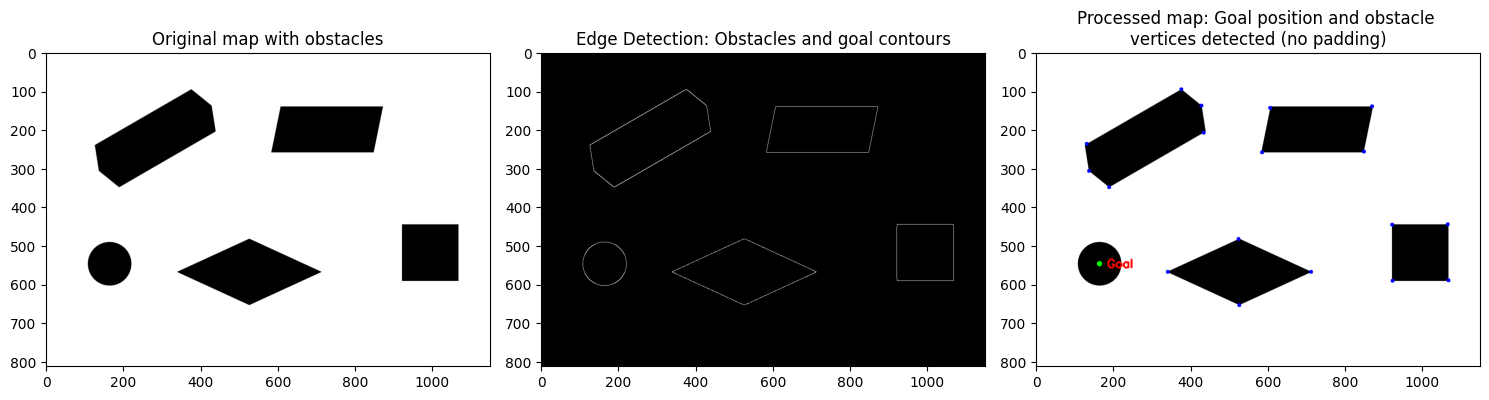

In [3]:
from matplotlib import pyplot as plt
from src.cv import *

map_with_obstacles = cv2.imread('./figures/obstacles.png')
map_with_obstacles_copy = map_with_obstacles.copy()

canny_img = preprocess_obstacles(map_with_obstacles)
obstacles_contours, _, goal_coords = detect_obstacles_and_goal(map_with_obstacles, 0)

draw_obstacles(map_with_obstacles_copy, obstacles_contours)
draw_goal(map_with_obstacles_copy, goal_coords)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(map_with_obstacles)
plt.title('Original map with obstacles')

plt.subplot(1, 3, 2)
plt.imshow(canny_img, cmap='gray')
plt.title('Edge Detection: Obstacles and goal contours')

plt.subplot(1, 3, 3)
plt.imshow(map_with_obstacles_copy)
plt.title('Processed map: Goal position and obstacle \nvertices detected (no padding)')

plt.tight_layout()
plt.show()

### Obstacle expansion

To prevent the Thymio from entering any obstacles, we expand them by adding a padding around their contours. This padding is computed for each contour, taking into account the center of the obstacle and the direction from the center to each vertex. We compute a unit vector from the center to each vertex, indicating the direction in which the padding should be applied. By multiplying this unit vector by the padding value and adding it to the vertex, we obtain new vertices that represent the expanded obstacle.

Below is an example of obstacle expansion:

<div style="text-align: center; margin-top:20px;">
    <img src='./figures/obstacle_expansion1.png' width='370'>
    <img src='./figures/obstacle_expansion2.png' width='400'>
</div>
<div style="text-align: center; margin-top:20px;">
    <strong>Obstacle Expansion</strong>
    <p style="font-size: 14px; color: #666;">Original vertices (left) vs. expanded vertices (right)</p>
    <p style="font-size: 14px; color: #666;"><strong>Note:</strong> The arrows next to x and y illustrate the direction of expansion for each vertex.</p>
</div>

Our algorithm also returns a mask of the expanded obstacles, which we use to build the visibility graph described in the global navigation section. The following code cell shows the result of our obstacle expansion:

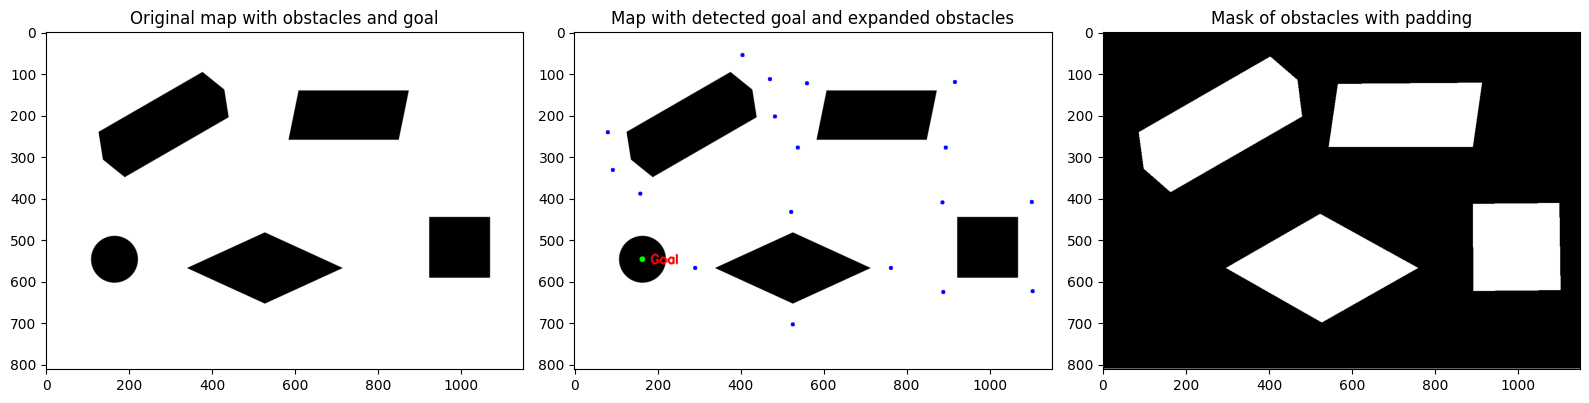

In [4]:
from matplotlib import pyplot as plt
from src.cv import *

PADDING_OBSTACLES = 50

map_with_obstacles = cv2.imread('./figures/obstacles.png')
map_with_obstacles_copy = map_with_obstacles.copy()

obstacles_contours, mask_obstacles, goal_coords = detect_obstacles_and_goal(map_with_obstacles, PADDING_OBSTACLES)
draw_obstacles(map_with_obstacles_copy, obstacles_contours)
draw_goal(map_with_obstacles_copy, goal_coords)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.imshow(map_with_obstacles)
plt.title('Original map with obstacles and goal')

plt.subplot(1, 3, 2)
plt.imshow(map_with_obstacles_copy, cmap='gray')
plt.title('Map with detected goal and expanded obstacles')

plt.subplot(1, 3, 3)
plt.imshow(mask_obstacles)
plt.title('Mask of obstacles with padding')

plt.tight_layout()
plt.show()

#### Thymio detection

We use an ArUco marker with the identifier 1 to detect the Thymio robot. This marker is attached to the top of the Thymio robot and is detected in every frame. By getting its 4 corners, we determine the position and orientation of the marker, which are then used by the Kalman filter to estimate the Thymio's position and orientation.

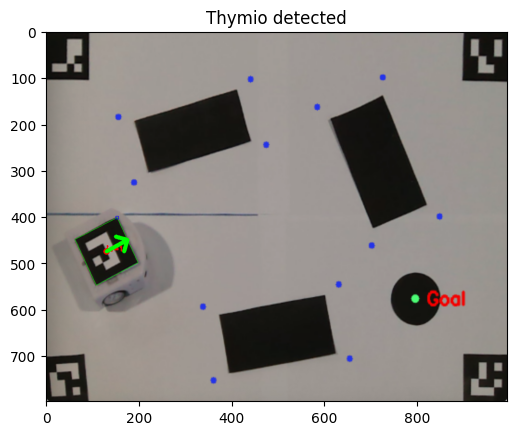

In [5]:
from matplotlib import pyplot as plt
from src.cv import *

frame_with_thymio = cv2.imread('./figures/map-cv.png')

thymio_coords = detect_thymio(frame_with_thymio, draw_aruco=True)

plt.imshow(frame_with_thymio)
plt.title('Thymio detected')
plt.show()

### 2.2. Path planning

**Responsible:** Charles Froessel

#### 2.2.1. Problem statement

Global path planning enables us to generate the trajectory to be followed by the thymio from a starting point to a goal point and to impose constraints on its movement (for example, obstacles that will be forbidden zones). The map detected by the vision component is a reduced representation of reality, and the choice of the global path planning algorithm is crucial in generating the robot's behavior, and will therefore influence its overall performance.

#### 2.2.2. Representation of the environment

In our case, there are many possible representation that we could use for the path planning, as we can make grids, cells, visibility graphs, etc. We chose to use a visibility graph to simplify and shorten calculations compared with grids, and to ensure optimal trajectories (in terms of distance) between the nodes (vetices of obstacles, goal, and starting point).

We thus have a map consisting of a set of nodes, and a mask that represents obstacles: 
- starting position (1 node)
- goal position (1 node)
- obstacle vertices (the number depends on the number of obstacles, and varies in the range [0;~10^2])
- obstacle mask (a black and white image that shows the obstacles in the map)

Each node contains 3 pieces of information:
- its number, or index
- its position in (x,y) coordinates

#### 2.2.3. Desired behaviour of the path planning

First, the obstacle mask is used to check whether two nodes are connected (or visible to each other): two nodes separated by an obstacle cannot, therefore, be connected in our visibility graph. Moreover, two different nodes should be connected, even if a large distance separates them, since they can see each other. 
<div style = 'text-align: center; margin-top: 30px;'>
    <img src='./figures/case5.png', width='800'>
</div>

The mask of obstacle (in red) corresponds to the obstacle that has been enlarged by the Thymio's width. The black shape represents the actual size of the obstacle.  In all the other images in this section, for simplicity, the obstacle mask will be reffered as "obstacle" and we will not talk further of the real obstacle.

(from course: *"Note that most existing techniques assume a mass-less, holonomic, pointlike robot => may require low-level motion control and **a priori expansion of obstacles** to be implemented robustly"*)

<div style = 'text-align: center; margin-top: 30px;'>
    <img src='./figures/case1.png', width='800'>
</div>

Here (see image above), the goal and the Thymio can be directly connected by a straight-line trajectory that doesn't cross any obstacles (green line on the image above). We therefore want our program to detect that these two nodes are connected (despite their wide spacing). On the contrary, two nodes separated by an obstacle should be marked as unconnected (black line on the image above).

<div style = 'text-align: center; margin-top: 30px;'>
    <img src='./figures/case2.png', width='800'>
</div>

We also want obstacle contours to be marked as feasible for the robot, so the obstacle mask must be smaller than the nodes location (the red square on the image is the mask of the obstacle, and the obstacle vertices are put farther). The spacing between the vertices and the mask has been exagerated for representation purpose. 

<div style = 'text-align: center; margin-top: 30px;'>
    <img src='./figures/case3.png', width='800'>
</div>

Finally, we want to evaluate the optimal trajectories when several objects are present: the figure above shows all the connection possible between two nodes of two seperate obstacles.

#### 2.2.4. Algorithm and implementation

We decided to take an nxn matrix, which takes node numbers as indices. 0 everywhere, and 1 at row i column j if node i is connected to node j. This matrix is called the connectivity matrix. It lets us know which nodes are neighbors, which will be useful for the fastest path resolution algorithm. 

#### 2.2.5. Implementation

The first step is collecting the data from the computer vision component, including (in this order):
- the Thymio's starting position 
- the Thymio's goal position
- obstacle vertices' positions
- mask of the obstacle (a black and white image)

All the positions are given in pixels.

```py
###################################### import data from CV            ####################################################################
Starting_node_pos=np.array(Starting_node_pos, dtype=np.int32)      ## converts the start node in an np.array
Arrival_node_pos=np.array(Arrival_node_pos, dtype=np.int32)         ## converts the goal node in an np.array
Nodes.insert(0, Starting_node_pos)                                  ## add those nodes (start and goal) to the list of nodes.
Nodes.insert(1, Arrival_node_pos)

Starting_node = 1            ### index OF THE START AND GOAL   (Change only for testing!)
Arrival_node = 0
###################################### end from CV        ################################################################################
```

We then create a unique list (or np.array) that concatenates all the nodes (Goal node position, arrival node position, and all obstacle vertices). Nodes[i] outputs the x and y position of the node of index i:  Nodes[i] = np.array([node_i_x, node_i_y]). The indices of the nodes of the starting and goal position stays always the same: 0 and 1 respectively.

The second step is creating a node network with the correct node connections and distances:
- the "Connectivity_matrix" is a square upper triangular matrix of size (number of nodes). It is 'True' in row i, colomn j if node i is connected to node j, and is False otherwise.
- the "Distance_between_nodes" is a square upper triangular matrix of size (number of nodes). For the nodes i and j that are connected, this matrix record the distances between the nodes i and j.

```py
####################################### Start Djikstra - calculate connectivity and distances 
Number_nodes = len(Nodes)
Connectivity_matrix = np.zeros((Number_nodes, Number_nodes), dtype=bool)      ##Connectivity_matrix[i, j] = 1 means i connected to j !!!!!!!!!!!!!!!!! i<j !!!!!!!!!! Matrix verifying if i and j are connected. 1 ou 0 (triangulaire supperieure)
Distance_between_nodes = np.full((Number_nodes, Number_nodes), np.inf)  #Initialise distances at infinity, to be changed.Also a matrice that is triangular supperior. The diagonal should be 0, but since we don't use it we don't lose time doing it
Starting_time=time.time()

for j in range(Number_nodes):
    for i in range(j):        #Connectivity_matrix[i, j] = 1 means i connected to j !!!!!!!!!!!!!!!!! i<j !!!!!!!!!!    i in range(j) compared to i in range(Number_nodes) increases the speed by two.
        Blank_img=np.zeros(shape=Mask.shape, dtype=np.uint8)   #(https://medium.com/jungletronics/opencv-image-basics-2e63d973851a) # Blank image for addinf segment
        cv2.line(Blank_img,Nodes[i],Nodes[j],(127,127,127),1)
        if(np.sum(cv2.bitwise_and(Blank_img, Mask))<=Threshold):
            Connectivity_matrix[i,j]=True
            Distance_between_nodes[i,j] = np.linalg.norm(Nodes[i]-Nodes[j])    ## l2-norm for distance
```

In this part of the code, we initialize the connectivity matrix as well as the distances between nodes. Each connection is tested only once (cf. for i in range(j)). This permits to avoid computing twice each connection, saving computation time: by doing this we divide by two the computation time of these matrices (we save even more time by not computing the diagonals).

To check if two nodes are connected, we trace a white line on a black background, connecting the two nodes. Then, we check the intersection between this image and the mask of enlarged obstacles (cv2.bitwise_and(Blank_img, Mask)). We compare it with a threshold value that was originally designed for potential noise in the mask, but it turned out to be useless in the final code, so that it is set to one. 

If the nodes are connected, the intersection of the two images will be a black image. If there is intersection (meaning the straight line between the two nodes is intersecting an obstacle), then the intersection image will contain some white pixels, and by summing all the pixels value, we will get a non-zero result. Moreover, to compute the distance between two nodes, we used the l2-norm, since our map is a physical map, and the Thymio can go in diagonals.

**Backtracking (Dijkstra update)** (inspired from https://www.freecodecamp.org/news/dijkstras-algorithm-explained-with-a-pseudocode-example/)

Some pseudocode of the implemented algorithm:

``````{r, tidy=FALSE, eval=FALSE, highlight=FALSE }

(n = number of nodes)
Distance_between_nodes[i][j] = distance between nodes i and j (n*n upper triangular matrix) (set to inf if i not connected to j) (i<j)
Visited_nodes = n vector with only 'False'
Unvisited_nodes = n vector with only 'True'
Previous = n vector that stores for each node the previous node in the path that gave its cost, or distance from start. Values set to Nan.

while Visited_nodes[Goal_node] is not 'True':
    Actual_node = Unvisited_nodes[argmin(Distance_from_start[Unvisited_nodes])]                (Actual_node is set to be the unvisited node that is the closest from start)
    for all neighbours of Actual_node:
        if all Unvisited_nodes have infinite distance print "There is no path between start and goal" and terminate the function
        if Distance_from_start[neighbour] < Distance_from_start[neighbour] + Distance_between_nodes[Actual_node][neighbour]
            Distance_from_start[neighbour] = Distance_from_start[neighbour] + Distance_between_nodes[Actual_node][neighbour]
            Previous[neighbour] = Actual_node
    Visited_nodes[Actual_node] = 'True'

    if it's taking too much time, terminate the function```

At the end of this code, we obtain a vector "Previous" that contains, for each node, the previous node the optimal path from the start to arrive at this node. Note that some nodes can (and most of the time will) be not visited, thus their distance from start is set to infinity and there is no previous node. 

Finally, to obtain the global path, we use the code below:

```py
    ######################################   GENERATE OUTPUT vector 
    Global_path = deque(Nodes[Arrival_node])
    Actual_node = Arrival_node
    while Actual_node!=Starting_node:     ####looks at the end, what is previous node of actual, previous of previous etc....
        Global_path = np.vstack([Global_path, Nodes[int(Previous[Actual_node])]]) 
        Actual_node= int(Previous[Actual_node])
```

We added two exit conditions: one corresponds to the aforementionned timeout, if the algorithm takes too much time to calculate the path, it means that there is too much nodes to compute. The usual computation time of the path planning algorithm is 0.1 second, and the timeout variable is set to 10 seconds. The second exit condition is when all the nodes that are achievable from the start position do not contain the goal position. For example, if the goal is surrounded by obstacles.

#### 2.2.5. Use case example

### 2.3. State estimation

**Responsible:** Jiwon You

#### 2.3.1 Problem Statement
The state estimation component is responsible for estimating the Thymio's position, orientation, linear and angular velocity in real-time. It will integrate knowledge of Thymio kinematics model, measurements from the camera, measurements from Thymio speed sensors to predict and update Thymio state. Thymio is a nonlinear time-variant system and Thymio state will roughly follow a Gaussian distribution. Thus, we will use Extended Kalman Filter for state estimation.

#### 2.3.2 System Identification of a differetial drive robot
Below are the names to denote state/control variables of Thymio. \
\
$u_l$ = left motor control input, `motor.left.target` \
$u_r$ = right motor control input, `motor.right.target` \
$u_{l,m}$ = measured left motor speed, `motor.left.speed` \
$u_{r,m}$ = measured left motor speed, `motor.right.speed` \
$v_{l}$ = linear velocity of left wheel \
$v_{r}$ = linear velocity of right wheel \
$v$ = linear velocity of Thymio \
$w$ = angular velocity of Thymio 

First, in `calibration.ipynb` We ran calibration code from exercise 8 to discover relationship between motor speed and linear velocity of Thymio. We will mainly use $u_l$ and $u_r$ around 100 to control Thymio, so we investigate linear velocity and motor speed variance at $u=100$. Moreover, we assume that conversion between motor speed and linear velocity is linear around this point.

<div style="text-align: center; margin-top:20px;">
    <img src='./figures/ground_sensor.png' width='600'>
</div>

Knowing that there is a thin white stripe between black blocks every 5cm, we can detect peaks from ground sensor and compute linear speed from the time it took to cross 6 blocks.

It returned linear velocity = `3.26cm/s` for motor speed 100, and thus conversion factor from motor speed to linear velocity was `0.0326`

<div style="text-align: center; margin-top:20px;">
    <img src='./figures/target_and_measured_speed_of_motor.png' width='600'>
</div>

In the histogram below, measured motor speed forms a Gaussian distribution around motor target speed of 100.

<div style="text-align: center; margin-top:20px;">
    <img src='./figures/measured_motor_speed_histogram.png' width='600'>
</div>

With $\alpha$ as conversion factor and $L$ as Thymio wheel axle length,  \
$v_l = \alpha u_l$ \
$v_r = \alpha u_r$ \
$v = \frac{v_l + v_r}{2}$ \
$w = \frac{v_r - v_l}{L}$ \
Conversion between $v,w$ and $u_l, u_r$ is implemented in `utils.py`.
$$
\begin{align*}
\begin{bmatrix}
v \\
w
\end{bmatrix}
&= TuningMatrix \cdot
\begin{bmatrix}
\frac{\alpha}{2} & \frac{\alpha}{2} \\
\frac{-\alpha}{L} & \frac{\alpha}{L} 
\end{bmatrix} \cdot
\begin{bmatrix}
u_l \\
u_r
\end{bmatrix} = A\cdot u 
\end{align*}
$$ //
```py
    import numpy as np
    wheel_axle_length = 9.5 # in cm
    thymio_speed_to_cms = 0.03260
    A_theory = thymio_speed_to_cms* np.array([[0.5, 0.5],[-1/wheel_axle_length, 1/wheel_axle_length]]) # theoretical kinematics model, but is overestimating
    tuning_matrix = np.array([[1.65,1.65],[2,2]])# compensate for overestimation
    A_tuned = np.multiply(tuning_matrix, A_theory)

    def from_u_to_vw(ul, ur):
        vw = A_tuned@np.array([ul, ur]) 
        return vw[0], vw[1] # returns v, w in cm/s, rad/s

    def from_vw_to_u(v,w):
        A_inv = np.linalg.inv(A_tuned)
        ulur = A_inv @ np.array([v,w]) 
        return int(ulur[0]), int(ulur[1]) # returns ul, ur as int
```
Note that in reality, theoretical conversion model was underestimating actual v and w. For a quick fix, we added empirically tuned `tuning_matrix` to compensate for underestimation. 

Let $X = (x,y,\theta, v, w)^{T}$ denote Thymio state. Discrete time motion model of Thymio is as follows. In particular, we use $v_{i}$ and $w_{i}$ as a temporary prediction of $v_{i+1}$ and $w_{i+1}$ and later update it with velocity measurements. This is reasonable because in our control policy Thymio is moving at constant speed in each control phase(`path_following`, `local_avoidance`, `get_back_to_path`, which will be further explained in motion control section). 
$$
\begin{align*}
X_{i+1} 
&= f(X_i, u_i) \\
&=
\begin{bmatrix}
x_i + v_i\cdot cos(\theta_i)\Delta t\\
y_i + v_i\cdot sin(\theta_i)\Delta t\\
\theta_i + w_i\cdot\Delta t \\
v_{i}\\
w_{i}
\end{bmatrix} \\
\end{align*}
$$ 
This is implemented in `ExtendedKalmanFilter.move(u)` of `kalman.py`, which is  the state prediction step.
```py
    def move(self, u):
        assert(u.shape[0] == 2) # u is np.array containing v_,w_
        x,y,theta,v,w = self.X
        # v_, w_ = u
        self.X[0] = x + v*np.cos(theta)*self.dt 
        self.X[1] = y + v*np.sin(theta)*self.dt
        self.X[2] = self.clip_theta(theta + w * self.dt)
        self.X[3] = v 
        self.X[4] = w
``` 

#### 2.3.2 Process and measurement noise
For Kalman Filter, let Q denote process noise matrix, R measurement noise matrix, $R_c$ camera noise matrix, $R_{vw}$ linear/angular velocity measurement noise matrix. Since we can't really estimate process noise, we used empirical tuning for Q. 
$$
R = 
\begin{bmatrix}
R_c & 0 \\
0 & R_{vw}
\end{bmatrix}
$$
Measurement noise is split into camera noise and vw noise. It is safe to assume that camera noise and vw noise are uncorrelated, and thus R is in block diagonal form.

Camera measures position and orientation, while Thymio speed sensors measure linear and angular velocity.
$z = (x_{cam}, y_{cam}, \theta_{cam}, v_{thy}, w_{thy})$

Camera measurements are faily accurate, and we can use a small value for camera noise. However, when aruco marker on Thymio is blocked, camera cannot detect Thymio. For such case, camera will return $(x_{cam}, y_{cam}, \theta_{cam}) = (0, 0, 0)$ and camera noise will be set to infinity, which excludes camera measurement from updating Thymio state. This is implemented in `ExtendedKalmanFilter.switch_mode()` of `kalman.py`.
```py
    NOISE_COV_CAMERA = 0.0001*np.eye(3)
    NOISE_COV_CAMERA_BLOCKED=9999999*np.eye(3)
    def switch_mode(self, camera_blocked):
        if camera_blocked and self.camera_available:
            self.R[0:3, 0:3] = NOISE_COV_CAMERA_BLOCKED
            self.camera_available = False
        elif not camera_blocked and not self.camera_available:
            self.R[0:3,0:3] = NOISE_COV_CAMERA
            self.camera_available = True
``` 
We have previously seen that motor speed measurement noise resembles Gaussian. Since we have direct access to motor speed measurement, we can easily compute motor speed variance. We assume that noise from left and right motor are uncorrelated.

<div style="text-align: center; margin-top:20px;">
    <img src='./figures/target_and_measured_speed_of_motor.png' width='600'>
</div>

Then using linear transformation from `utils.py`, we can convert motor speed variance to linear/angular velocity variance. As in 2.3.1, $\alpha$ denotes Thymio speed conversion factor.
$$
\begin{align*}
\begin{bmatrix}
v \\
w
\end{bmatrix}
&= TuningMatrix \cdot
\begin{bmatrix}
\frac{\alpha}{2} & \frac{\alpha}{2} \\
\frac{-\alpha}{L} & \frac{\alpha}{L} 
\end{bmatrix} \cdot
\begin{bmatrix}
u_l \\
u_r
\end{bmatrix} = A\cdot u \\
\Sigma_{u} &= 
\begin{bmatrix}
\sigma_{ul}^2 & 0 \\
0 & \sigma_{ur}^2
\end{bmatrix} \\
\Sigma_{vw} &= A\Sigma_{u} A^T
\end{align*}
$$ //
```py
    from utils import A_tuned
    var_l_speed = np.var(l_speed[idx:]) # took from idx to avoid the initial transient and devid by the conversion factor
    var_r_speed = np.var(r_speed[idx:])
    cov_vw = A_tuned @ np.array([[var_l_speed,0],[0, var_r_speed]]) @ A_tuned.T
```
$$
R_{vw} =
\begin{bmatrix}
0.0227 & -0.0022 \\
-0.0022 & 0.0014
\end{bmatrix}
$$
Note that $R_{vw}$ is not diagonal. This agrees with our intuition that linear/angular velocity noise are correlated.
#### 2.3.3 Extended Kalman Filter implementation
Since our Thymio is a time-variant nonlinear system and noises can be assumed as Gaussian, we are using Extended Kalman Filter.
$$
\begin{align*}
X_{i+1} 
&= f(X_i, u_i) \\
&=
\begin{bmatrix}
x_i + v_i\cdot cos(\theta_i)\Delta t\\
y_i + v_i\cdot sin(\theta_i)\Delta t\\
\theta_i + w_i\cdot\Delta t \\
v_{i}\\
w_{i}
\end{bmatrix} \\
y &= h(X) = X
\end{align*}
$$ 
First we compute Jacobian of $f(X_i, u_i)$ to linearize our system.
$$
\begin{align*}
F
&= \frac{\partial f(X,u)}{\partial X} \bigg|_{X_i, u_i}
&=
\begin{bmatrix}
1 & 0 & -sin(\theta)v\Delta t & cos(\theta)\Delta t & 0 \\
0 & 1 & cos(\theta)v\Delta t & sin(\theta)\Delta t & 0 \\
0 & 0 & 1 & 0 & \Delta t \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix} 
\end{align*}
$$
Predict state covariance
$$
P = FPF^{T}+Q
$$
Predict state
$$
\bar X = f(X,u)
$$
Measurement residual. For our case, measurement funtion $h(X)$ is an identity function that returns $X$, and thus Jacobian of $h(X)$ is an identity matrix.
$$
y = z - h(X) = z - X
$$
$$
H = \frac{\partial h(X)}{\partial X} = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1\\
\end{bmatrix}
$$
Residual covariance
$$
S = HPH^{T}+R
$$
Near optimal Kalman gain
$$
K = PH^{T}S^{-1}
$$
update state
$$
X = X + Ky
$$
update state covariance
$$
P = (I-KH)P
$$
This is implemented in `ExtendedKalmanFilter.predict_and_update()` of `kalman.py`.
```py
    def predict_and_update(self, u, z):
        assert(u.shape[0] == self.control_dim)
        assert(z.shape[0] == self.measurement_dim)
        # prediction step
        F = self.compute_F()
        self.move(u)
        self.P = F @ self.P @ F.T + self.Q

        #update step
        y = z - self.X # use measurement model H(X) = X
        y[2] = self.clip_theta(y[2]) # clip theta to prevent overflow
        S = self.H @ self.P @ self.H.T + self.R
        S_inv = np.linalg.inv(S)
        K = self.P @ self.H.T @ S_inv
        self.X = self.X + K @ y
        self.P = (np.eye(self.state_dim) - K @ self.H) @ self.P
        self.state_trajectory.append(self.X)
``` 
Consider a case where $\theta_{i+1} = 0.01, \theta_i = 2\pi - 0.01$. Simple subtraction would yield 
$$ 
\Delta\theta = \theta_{i+1} - \theta_i = 0.02 - 2\pi
$$
, but the value should be just 0.02.

To prevent such overflow, we use `ExtendedKalmanFilter.clip_theta()` to keep $\theta$ values in the range of $[-\pi, \pi]$.
```py
    def clip_theta(self, theta):
        return (theta + np.pi) % (2 * np.pi) - np.pi
``` 
In `kalman.ipynb` We tested our implementation with a simple simulation under noise. Despite initial state with large error, EKF is able to converge to true state.

<div style="text-align: center; margin-top:20px;">
    <img src='./figures/ekf_simulation.png' width='600'>
</div>

### 2.4. Motion Control

**schematic of how motion control work**

<div style="text-align: center;">
    <img src="figures/motion_control.jpg" alt="motioncontr" style="width:70%;"/>
</div>

**function : 'find_how_go' to next target**
<br>

In `path_following` mode, Thymio will turn until its heading is aligned with the path, and then move forward in a straight line. This is ideal for following a piecewise straight path. If Thymio turns and moves forward simultaneously, it will move in a smooth curve and diverge from global path.

code:
```py
    dx = x_goal - x
    dy = y_goal - y

    # Conversion in polar coordinates
    alpha = np.arctan2(dy, dx) - theta  # angle relative to the target
    alpha = (alpha + np.pi)%(2*np.pi) - np.pi

    desired_theta = np.arctan2(dy, dx)
    dtheta = (desired_theta - theta + np.pi)% (2*np.pi) - np.pi
    if abs(dtheta) > 3*np.pi / 180: # abs(dtheta) larger than 3 degree
        v_ = 0
        w_ = np.sign(dtheta)*0.314 #turn on himself
    else:
        v_ = 3.3 #go straight
        w_ = 0
    return v_, w_
```

### 2.5. Obstacle avoidance

**Responsible:** Johann Lugon-Moulin

We have decided that for the local avoidance we use only the IR proximity sensors to detecte and go around the obstacle. Our policy is robust and works well even in the absence of camera(that is, Extended Kalman Filter is only using velocity measurements and state estimation is inaccurate)

**Step1** 
<br> 

In `path_following` mode, Thymio is moving towards `next_target` popped from global path.

<div style="text-align: center;">
    <img src="figures/localnav_step1.png" alt="Step1" style="width:50%;"/>
</div>


**Step 2** 
<br> 

Obstacle detected with IR sensor . Change motion control mode to `local_avoidance` and then compare left / right sensor values to decide if local obstacle is on the left or right side. Remember whether wall is on left or right, and remember position and heading at the entrance point $X_{entrance}$  and $Y_{entrance}$ and  $\alpha_{entrance}$.
$$
\text{Sensors left} > \text{Sensors right} \implies \text{wall\_on} = \text{left}
$$

$$
\text{Sensors right} > \text{Sensors left} \implies \text{wall\_on} = \text{right}
$$

<br>
<div style="text-align: center;">
    <img src="figures/localnav_step2.png" alt="Step2" style="width:50%;"/>
</div>
<br>
Code:
<br>

```py
   if self.control_mode == "path_following":
            activate_local_avoidance = local_avoidance.check_obstacle(prox_horizontal)
            if activate_local_avoidance:
                self.control_mode = "local_avoidance"
                self.local_nav.initialize(prox_horizontal)
                print("local avoidance activated")
                self.x_entrance = x
                self.y_entrance = y
                self.alpha_entrance = theta
``` 
```py
        def initialize(self, prox_horizontal):
        if prox_horizontal[0]+ prox_horizontal[1]<=prox_horizontal[3] + prox_horizontal[4]:
            self.wall_on = "right"
            self.mode = "turning"
            print(f"local nav mode = {self.mode}, wall on {self.wall_on}")
        else:
            self.wall_on = "left"
            self.mode = "turning"
            print(f"local nav mode = {self.mode}, wall on {self.wall_on}")
```

**Step 3**
<br>

Local avoidance starts with `turning`. If the wall is on left, Thymio will keep turning right until it doesn't see the wall on left anymore. This gives enough clearance and ensures that when Thymio moves forward, it will not crash into the wall. Then local avoidance switches to `wall_following` 
<br>
<div style="text-align: center;">
    <img src="figures/localnav_step3.png" alt="Step3" style="width:50%;"/>
</div>
<br>
code:
<br>

```py
    if self.mode == "turning":
            if self.wall_on == "right":
                v = -1
                w = 0.314
                if all(np.array(prox_horizontal[2:]) < 150):
                    self.mode = "wall_following"
                    print(f"{self.mode} on {self.wall_on} activated")
            elif self.wall_on == "left":
                v = -1
                w = - 0.314
                if all(np.array(prox_horizontal[0:3]) < 150):
                    self.mode = "wall_following"
                    print(f"{self.mode} on {self.wall_on} activated")
```

**Step 4**
<br>

Thymio is now in `wall_following` mode. Thymio must avoid the wall, but at the same time stay on the wall. While Thymio can detect the wall on left, Thymio will keep moving forward and slightly turn right to avoid the wall. If IR sensor cannot see wall on left anymore, Thymio will move forward and turn slightly left to see the wall again. 
<br>
<div style="text-align: center;">
    <img src="figures/localnav_step4.png" alt="Step4" style="width:50%;"/>
</div><br>
code :
<br>

```py
     elif self.mode == "wall_following":
            if self.wall_on == "right":
                if all(np.array(prox_horizontal[2:]) < 150): # not seeing the wall on right, turning right
                    v, w = 3, -0.25
                else: # seeing the wall, move and turn slightly left
                    v, w = 3, 0.3
            if self.wall_on == "left":
                if all(np.array(prox_horizontal[0:3]) < 150): # not seeing the wall on left, turning left
                    v, w = 3, 0.25
                else: # seeing the wall, move and turn slightly right
                    v, w = 3, -0.3
```

**Step 5**
<br>

Thymio checks if it is back on path, by comparing the angle between its current position(blue) and entrance position(green) to its entrance heading. If the difference is small enough, Thymio is back on path and changes motion control mode to `get_back_to_path`. 
<br>

if $$arctan ((y - y_{entrance}) / (x – x_{entrance})) == \alpha_{entrance}$$ Change motion control mode to `get_back_to_path` and remember the exit position (x,y)
<br>


<br>
<div style="text-align: center;">
    <img src="figures/localnav_step5.png" alt="Step5" style="width:50%;"/>
</div>
<br>
Code:
<br>

```py
    elif self.control_mode == "local_avoidance":
                get_back_to_path = self.activate_get_back_to_path(x,y, theta)
                if get_back_to_path:
                    print("getting back to path activated")
                    self.control_mode = "get_back_to_path"
                    self.x_exit = x
                    self.y_exit = y
```

```py
    def activate_get_back_to_path(self, x, y, theta):
        dy = y - self.y_entrance
        dx = x - self.x_entrance
        alpha = np.arctan2(dy, dx)
        d_alpha = (alpha - self.alpha_entrance + np.pi) % (2*np.pi) - np.pi
        return ( abs(d_alpha) < 0.1 and np.sqrt(dy**2 + dx**2) > 5 ) # if alpha is small enough, assume that Thymio is back on track
```

**Step 6**
<br>

Thymio's position is back on path, but it's still close to local obstacle and heading is wrong by a large margin. Therefore we add a recovery phase called `get_back_to_path` to recover heading and get away from the obstacle. When Thymio is 3 cm away from the exit point(enough clearance for Thymio) we change the motion control mode to `path_following`. During local avoidance, Thymio was entirely focused on avoiding the obstacle and didn't care about the global path. It is often the case that Thymio goes past the `next_target` or significantly diverges from the original global path. Therefore, we recompute global path. 
<br><br>
<div style="text-align: center;">
    <img src="figures/localnav_step6.png" alt="Step6" style="width:50%;"/>
</div>
<br>
code:
<br>

```py
   elif self.control_mode == "get_back_to_path":
            if self.local_nav.wall_on == "right":
                v, w = 2, 0.314
            else:
                v, w = 2, -0.314
```    

```py
   elif self.control_mode == "get_back_to_path":
            distance = np.sqrt((x - self.x_exit)**2, (y - self.y_exit)**2)
            if distance > 3: # has moved far enough from exit point
                self.control_mode = "path_following"
                recompute_global_path = True
                print("path following activated activated")
``` 

**Step 7**
<br>

Thymio take the new path and go to the next target.
<br>
<div style="text-align: center;">
    <img src="figures/localnav_step7.png" alt="Step7" style="width:50%;"/>
</div>

## 3. 💻 Running the project

Before running the project please ensure you have the following dependencies installed:

- `opencv-python`
- `numpy`
- `matplotlib`
- `opencv-python`
- `opencv-contrib-python`

Or run the following command to install them:

```bash
pip install -r requirements.txt
```

Also, make sure you:

1. Set the correct `CAMERA_ID` in `src/main.py`. This can be 0 or 1.
2. Connect the Thymio robot to the computer via USB.
3. Use the materials provided in the `map` folder to create the map.

Finally, to run the project, you should follow these steps:

1. Run the `src\main.py` script.
1. Press `m` key to detect the map, obstacles, goal and fix map perspective.
2. After placing Thymio on the map, press `p` key to find global path and start motion.
3. Press `q` key to stop the program.

#### 3.1 Explanation of main loop

Main loop roughly consists of 3 parts; map detection, path planning and start motion. Step 1 is run only once in the beginning. There are various flags such as `kidnapping`, `start_motion` and `path_planning` to activate or deactivate step 2 and 3.
```py
    while True:
        if map_detection:
            # Step 1: Detect the map
        if path_planning:
            # Step 2: Path planning
        if start_motion:
            # Step 3: Start motion
``` 

'start_motion' step is the actual control loop, whose steps are roughly as follows.

```py
    if start_motion:
        # get data from camera
        # get data from Thymio
        # check if Thymio is visible on camera
        # check if Thymio is kidnapped
        # update Thymio state using EKF
        # check if next target is reached
        # compute control input and set Thymio target velocity
``` 

`path` variable is a list of nodes to visit, including the goal. `next_target` is the next node to visit. Every time a node is reached, Thymio pops its `next_target` from `path`. If `path` is empty, it means Thymio has reached the goal and the main loop terminates.
```py
    target_reached = np.linalg.norm(np.array([x - next_target[0], y - next_target[1]])) < epsilon
    if target_reached:
        if len(path) == 0:
            print("Goal reached, terminating...")
            break
        else:
            print("Heading towards next waypoint")
            next_target = path.pop(0)
``` 
When Thymio detects kidnapping from acceleration, it sets motor target speed to 0 and activates `path_planning`. 
```py
    # to detect kidnapping
    if abs(acc[2]-22)>4: # sudden change in acc_z indicates kidnapping
        print("kidnapping detected")
        kidnapping = True
        thymio.node.send_set_variables(motors(0,0))
        # computes new global path in the next iteration
        path_planning = True
        continue
``` 
Thymio will start moving only when a new path is computed, and a new path is computed only when kidnapping is over. We use ground sensors to check if kidapping is over, because acceleration sensor cannot differentiate between being on the ground and being held still in the air.
```py
    if path_planning:
        if kidnapping:
            aw(thymio.client.sleep(dt))
            data = thymio.get_data()
            prox_ground_delta = data[2]
            print(f"kidnapping, {prox_ground_delta[0]}")
            if prox_ground_delta[0] > 700: 
                kidnapping = False # kidnapping is over
                print("kidnapping finished")
                continue
        if thymio_found and goal_coords and not kidnapping:
            obstacle_vertices = get_obstacle_vertices(obstacles_contours)
            global_path = compute_global_path(thymio_coords, goal_coords, obstacle_vertices, mask_obstacles)
            # ...
            path = global_path.copy().tolist()
            # global_path is for visualization, and thus in pixel coordinates
            # convert to xy coordinates in centimeters
            path = [convert_pixel_to_cm(target, REAL_MAP_WIDTH_CM, REAL_MAP_HEIGHT_CM, MAP_MAX_WIDTH, MAP_MAX_HEIGHT) for target in path]
            next_target = path.pop(0)
            # once path is computed, start motion and deactivate path planning
            start_motion=True
            path_planning = False
            mc.control_mode = "path_following"
``` 

Motion controller `mc` decides control phase, namely `path_following`, `local_avoidance.turning`, `local_avoidance.wall_following` and `get_back_to_path`. Nominal phase is `path_following`. When a local obstacle is first detected, Thymio will sequentially switch to `local_avoidance.turning`, `local_avoidance.wall_following` and `get_back_to_path` phase. 
``` py
    path_planning = mc.set_mode(prox_horizontal, x, y, theta)
    ul, ur = mc.compute_control(x, y, theta, next_target[0], next_target[1], prox_horizontal)
    thymio.node.send_set_variables(motors(ul, ur))
    aw(thymio.client.sleep(dt))
``` 
Note that during local avoidance, motion controller's primary goal is to avoid the local obstacle, and often moves past the next target node of the original global path. Therefore, when `get_back_to_path` is completed, we activate `path_planning` again.

Finally, when Thymio aruco marker is blocked and EKF is only using speed sensor measurements, state uncertainty will accumulate. To visualize this, we add position uncertainty ellipse, which is obtained from P matrix of `ekf`.
``` py
    xy_variance = ekf.P[0:2, 0:2]
    eigenvalues, eigenvectors = np.linalg.eig(xy_variance)
    ellipse_axis_length = convert_cm_length_to_pixel(np.sqrt(eigenvalues),REAL_MAP_WIDTH_CM, REAL_MAP_HEIGHT_CM, MAP_MAX_WIDTH, MAP_MAX_HEIGHT)
    ellipse_angle = np.arctan2(eigenvectors[0][1], eigenvectors[0][0])
    ellipse_angle = 90-np.rad2deg(-ellipse_angle)
    cv2.ellipse(map_frame, ekf_pixel, ellipse_axis_length, ellipse_angle, 0, 360, (0,255,255), 5)
``` 
**Schematics of main loop:**

<div style="text-align: center;">
    <img src="figures/bigschematics.jpg" alt="Schematics" style="width:50%;"/>
</div>

## 4. 📍 Conclusion

Our Thymio robot successfully navigates through environments with obstacles to reach a goal, and in different scenarios that include kidnapping, local avoidance and thymio's aruco marker being covered. Working on this system was an excellent way to understand the course material and apply it to a real-world problem. The main challenge we faced was integrating all the components, including camera, motion control, and Kalman filter. However, we were able to overcome these challenges by working together and exchanging ideas, and we learn a lot from this project.

Some areas that could be improved are the following:

- Image processing to clean the noise to work better in different lighting conditions: sunlight and shadows create noise in obstacle detection, sometimes causing obstacles to have more vertices than expected.
- Odometry: as even slight variations in wheel speed can lead to significant position estimation errors when relying solely on odometry.
- While the IR sensors provide good forward range detection, the robot would benefit from additional sensors on its left and right sides. This would enable better wall-following, particularly around 90-degree corners where the current configuration sometimes fails to detect nearby walls.

## 5. Demo videos

#### Path planning demo

<video width="700" height="400" controls>
  <source src="demo/demo_global.mp4" type="video/mp4">
</video>

#### Kidnapping demo

Every time Thymio detects kidnapping, it waits to be placed back on ground and recomputes global path

<video width="700" height="400" controls>
  <source src="demo/demo_kidnapping.mp4" type="video/mp4">
</video>

#### EKF demo

Green arrow marks camera measurements, purple arrow marks state estimation by EKF. When camera is blocked, EKF only uses odometry and speed sensor measurements to estimate Thymio state. Position uncertainty ellipse grows over time, and uncertainty along direction of motion is larger than uncertainty perpendicular to it. This is because Thymio is moving in a straight line, so there is less uncertainty related to turning 

When camera is available again, purple arrow quickly converges to green arrow

<video width="700" height="400" controls>
  <source src="demo/demo_ekf.mp4" type="video/mp4">
</video>

#### Local avoidance 1 demo

We can see the control mode shift from path planning to local avoidance, get back to path. At the end it recomputes global path

<video width="700" height="400" controls>
  <source src="demo/demo_local_1.mp4" type="video/mp4">
</video>

#### Local avoidance 2 demo

<video width="700" height="400" controls>
  <source src="demo/demo_local_2.mp4" type="video/mp4">
</video>

#### Demo of everything

At 3:46, when Thymio is kidnapped and placed inside global obstacle, path planning algorithm prints "No feasible path" because there is no feasible path.

<video width="700" height="400" controls>
  <source src="demo/demo_everything.mp4" type="video/mp4">
</video>

## 6. 📁 References

For computer vision an image processing we used the following resources:

1. **Detecting aruco markers with OpenCV and Python:** https://www.geeksforgeeks.org/detecting-aruco-markers-with-opencv-and-python-1/
2. **Aruco marker detection:** https://docs.opencv.org/3.4/d9/d6d/tutorial_table_of_content_aruco.html#:~:text=ArUco%20markers%20are%20binary%20square,pose%20estimation%20and%20camera%20calibration.
3. **OpenCV documentation for image processing:** https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
4. **Aruco marker angle calculation:** https://github.com/anish-natekar/OpenCV_ArUco_Angle_Estimation/blob/main/aruco_library.py
5. **Detect shapes in images:** https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/
6. **Contour feaures:** https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html

For the Extended Kalman Filter implementation we used the following resources:

1. Control your Thymio in Python, Basics of Mobile Robotics
2. Solution 8, Basics of Mobile Robotics
3. **Extended Kalman filter:** https://en.wikipedia.org/wiki/Extended_Kalman_filter
4. **filterpy:** https://github.com/rlabbe/filterpy 

For the local avoidance and motion we use the following ressources:
1. Control your Thymio in Python, Basics of Mobile Robotics
2. Solution 3, Basics of Mobile Robotics
3. Solution 4, Basics of Mobile Robotics


For the path planning we use the following ressources:
1. **Dijkstra algorithmic:** https://www.freecodecamp.org/news/dijkstras-algorithm-explained-with-a-pseudocode-example/
2. **To check intersection between nodes:** https://medium.com/jungletronics/opencv-image-basics-2e63d973851a
3. https://pyimagesearch.com/2021/01/19/opencv-bitwise-and-or-xor-and-not/

### Acknowledgement
Overall structure of ExtendedKalmanFilter class was inspired by https://github.com/grilloandrea6/mobile-robotics-project 